## Modelo dinámico para la propagación del virus COVID-19 en Colombia

A continuación se presenta el desarrollo de un modelo dinámico basado en el modelo epidemiológico SEIRV [en Wuhan, China](http://www.aimspress.com/article/10.3934/mbe.2020148) y, adaptado a la población colombiana (50 millones de habitantes aproxiadamente). 

El sistema sigue las siguientes ecuaciones diferenciales:

---

$$ \frac{dS}{dt} = \Lambda - \beta_1(E) E S - \beta_2(I) S I - \beta_3(V) S V - \mu S $$

---

$$ \frac{dE}{dt} =  \beta_1(E) E S + \beta_2(I) S I + \beta_3(V) S V - (\alpha + \mu) E $$

---

$$ \frac{dI}{dt} = \alpha E - (\omega + \gamma + \mu) I $$

---

$$ \frac{dR}{dt} = \gamma I - \mu R $$

---

$$ \frac{dV}{dt} = \xi_1 E + \xi_2 I - \sigma V $$

---

donde S es el número de personas sanas no infectadas, E el número de personas expuestas (portadores asintomaticos o sanos que propagan el virus), I las peronas enfermas, R las personas sanas que se recuperaron del virus y V es la concentración de virus en el ambiente

Las __Funciones de Contacto Directo__ (tasas $\beta$) toman la forma $$ \beta_i(x) = \frac{\beta_0(i)}{1 + c(i)x}  $$ siendo $\beta_1$ para el contacto E-S (transmisión directa expuestos-sanos), $\beta_2$ para el contacto (transmisión directa infectados-sanos) I-S y  $\beta_3$ para el contacto S-V (transmisión indirecta sanos-ambiente). Ademas, se tienen los siguientes valores para la constante de transmisión $\beta_0$ ($\frac{1}{persona \ dia}$) y  el coeficiente de ajuste para la transmisión $c$ ($\frac{1}{persona}$).

$$ \beta_0 = [1.5 \times 3.11 \times 10^{-9}, \ 1.5 \times 0.62 \times 10^{-9}, \ 1.5 \times 1.03 \times 10^{-9} ] $$

$$ c = [1.01 \times 10^{-4}, \ 1.01 \times 10^{-4}, \ 1.01 \times 10^{-4}  ] $$

cabe notar que los anteriores valores han sido adaptados a partir de los datos disponibles para Colombia. 

Por último, todos los __parámetros del modelo__ se describen a continuación:

$\Lambda \ (\frac{personas}{dia}) = 15.098 \times 5 \times 10^4 \times \frac{1}{365} $: Tasa de natalidad. se usa dato reportado por el banco mundial en el 2017. 

$\mu \ (\frac{persona}{dia}) = \frac{5.503 \times 5 \times 10^4}{5 \times 10^6 \times 365} $: Tasa de muertes naturales. Se usa dato reportado por el BM de 5.503 por mil habitantes.

$\alpha \ (\frac{1}{dia})=\frac{1}{7}$: Frecuencia de incubación.

$\omega \ (\frac{1}{dia})= 10^{-2} $: Tasa de muerte inducida por el virus.

$\gamma \ (\frac{1}{dia})= \frac{1}{15} $: Tasa de recuperación. 

$\xi_1 \ (\frac{1}{dia}) = 2.30$: Tasa de dispersión del virus al ambiente por los individuos sanos portadores.

$\xi_2 \ (\frac{1}{dia}) = 0$: Tasa de dispersión del virus al ambiente por los individuos enfermos.

$\sigma \ (\frac{1}{dia}) = 1$: Tasa de remoción del virus en el ambiente.

In [1]:
##=== Importando librerías ===##
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
##=== Definiendo valores de parametros==##

lbd = (15.098*5* 10**4) / 365 
mu = (5.503*5* 10**4) / (5* pow(10, 6) *365) 
alpha = 1/7
omega = pow(10,-2)
gamma = 1/15
xi_1 = 2.30
xi_2 = 0
sigma = 1

def betaf(i, x):
    b0 = [1.5*3.11*pow(10, -9), 1.5*0.62*pow(10, -9), 1.5*1.03*pow(10, -9)]
    c = [1.01*pow(10, -4), 1.01*pow(10, -4), 1.01*pow(10, -4)]
    
    b = b0[i-1] / (1 + c[i-1]*x)
    
    return b

##=== Definiendo sistema de ecuaciones ===##

def syst(y, t, beta, xi_2):
    S, E, I, R, V = y
    
    dS = lbd - beta(1, E)*E*S - beta(2, I)*S*I - beta(3,V)*S*V - mu*S
    dE = beta(1,E)*E*S + beta(2,I)*S*I + beta(3,V)*S*V - (alpha + mu)*E
    dI = alpha*E - (omega + gamma + mu)*I
    dR = gamma*I - mu*R 
    dV = xi_1*E + xi_2*I - sigma*V
    
    return [dS, dE, dI, dR, dV]

##=== Carga de datos en tiempo real ===##
def date_range(date_start='2/23/20',date_end='3/03/20',date_step=1):
    import datetime
    dr=[]
    start = datetime.datetime.strptime(date_start, "%m/%d/%y")
    end = datetime.datetime.strptime(date_end, "%m/%d/%y")
    step = datetime.timedelta(days=date_step)
    while start <= end:
        #avoid leading zeroes: https://stackoverflow.com/a/2073189/2268280
        dr.append(start.strftime("%-m/%-d/%y"))
        start += step
    return dr
def get_infected(country,date_start=None,date_end=None,
      data_source='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/',
      data_file='master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
      ):
    '''
    Obtenga la lista de infectados de un país
     country: País
     date_start: Fecha inicial en el formato MM/DD/YY, e.g. '3/10/20' o None
     date_end  : Fecha final en el formato MM/DD/YY, e.g. '3/10/20' o None
     si alguna de las fechas esta en None se toma de los extremos del rango
     de fechas disponible
    '''
    import datetime
    import pandas as pd
    import re

    cva=pd.read_csv('{}{}'.format(data_source,data_file))
    cva=cva.reset_index(drop=True)
    d=[ c for c in cva.columns if re.search(r'^[0-9]{1,2}\/[0-9]{1,2}\/[1920]{2}',c)]
    if not date_start:
        date_start=d[0]
    if not date_end:
        date_end=d[-1]
    dr=date_range(date_start=date_start,date_end=date_end)
    cvrg=cva[cva['Country/Region']==country].reset_index(drop=True)
    y=cvrg[dr].values.tolist()[0]
    return y       

para las __condiciones iniciales__ en la integración se tienen dos posibilidades, las dadas en el artículo para la epidemia de Wuhan después de la cuarentena ($sys0_w$) o, las condiciones iniciales para el inicio de la epidemia en una población de tamaño n ($sys0_n$)

$$ sys0_w = [8998505, 1000, 475, 10, 10000] $$
$$ sys0_n = [n, 0, 0, 0, 100] $$

In [0]:
##=== Definiendo condiciones iniciales ===##
sys0_w = [8998505, 1000, 475, 10, 10000]

def sys0_n(n): return [n, 0, 0, 0, 100]

##=== Definiendo tiempo de integración ===##
t = np.arange(0, 300)

In [0]:
##=== Integrando sistema de ecuaciones para colombia ===###
Col_sol = integrate.odeint(syst, sys0_n(5*10**7), t, args=(betaf, xi_2) )

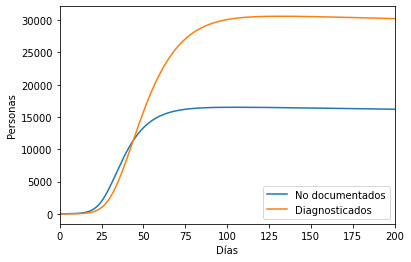

In [5]:
##=== Graficando primeros resultados ===###
plt.plot(t, Col_sol[:, 1], label="No documentados")
plt.plot(t, Col_sol[:, 2], label="Diagnosticados")
plt.xlabel("Días")
plt.ylabel("Personas")
plt.xlim(0, 200)
plt.legend()
plt.show()

Tomamos el número de casos reportados para __Colombia__ en los primeros 10 días después del primer paciente positivo para COVID-19 en el territorio y lo ajustamos a nuestro modelo

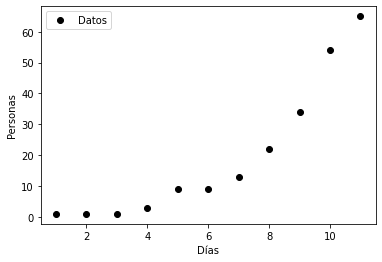

[1, 1, 1, 3, 9, 9, 13, 22, 34, 54, 65]


In [6]:
##=== Datos para Colombia ===##
ONLINE=True
if ONLINE:
    #NOTA: date_end=None toma la última actualización
    Col10=get_infected('Colombia',date_start='3/7/20',date_end='3/17/20')
else:
    Col10 = [1, 1, 1, 3, 3, 9, 9, 16, 24, 24, 45]

plt.plot(t[1:12], Col10, 'ko', label="Datos")
plt.xlabel("Días")
plt.ylabel("Personas")
plt.legend()
plt.show()
print(Col10)

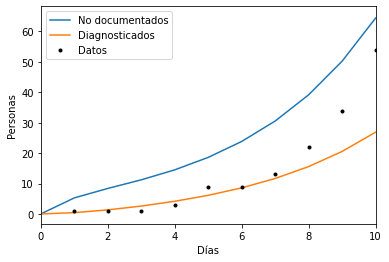

In [7]:
##=== Graficando primeros resultados y datos reportados ===###
plt.plot(t[0:11], Col_sol[0:11, 1], label="No documentados")
plt.plot(t[0:11], Col_sol[0:11, 2], label="Diagnosticados")
plt.plot(t[1:12], Col10, 'k.', label="Datos")
plt.xlabel("Días")
plt.ylabel("Personas")
plt.xlim(0, 10)
plt.legend()
plt.show()

A partir del modelo mostrado, se propone visualizar __como sería la propagación si no hay intervención__ al modificar las tasas de contacto $\beta_i$

In [0]:
##=== Definiendo función de contacto directo modificada ===##
def betaf_mod(i, xc, x):
    b0 = [1.5*3.11*pow(10, -9), 1.5*0.62*pow(10, -9), 1.5*1.03*pow(10, -9)]
    c = [0, 0, 0] 
    #c = [1.01*pow(10, -4), 1.01*pow(10, -4), 1.01*pow(10, -4)]
    
    if x<xc:
        b = b0[i-1]
    else: 
        b = b0[i-1]*(1+c[i-1]*xc) / (1+c[i-1]*x)
    
    return b

def beta_mod(i, x): # forma reducida para c=[0,0,0]
    b0 = [1.5*3.11*pow(10, -9), 1.5*0.62*pow(10, -9), 1.5*1.03*pow(10, -9)]
    b = b0[i-1]
    return b

In [0]:
##=== solucionando ecuaciones para tasas modificadas ===##
Col_sol_mod = integrate.odeint(syst, sys0_n(5*10**7), t, args=(beta_mod, xi_2) )

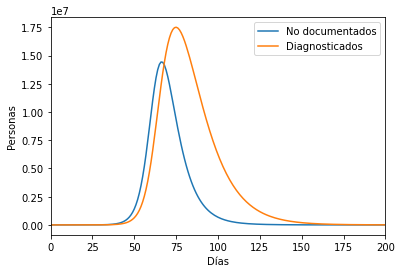

In [10]:
##=== Graficando nuevos resultados ===###
plt.plot(t, Col_sol_mod[:, 1], label="No documentados")
plt.plot(t, Col_sol_mod[:, 2], label="Diagnosticados")
plt.xlabel("Días")
plt.ylabel("Personas")
plt.xlim(0, 200)
plt.legend()
plt.show()